# Numerical Solution of the Ramsey/Cass-Koopmans model

## Mateo Velásquez-Giraldo

## (adapted from Alexander Tabarrok and Christopher D. Carroll)






This notebook implements a class representing Ramsey's growth model. Current utilities include:
- Numerically finding the consumption rule through 'time elimination', as implemented by Alexander Tabarrok and Christopher D. Carroll's [Wolfram Mathematica notebook](www.econ2.jhu.edu/people/ccarroll/public/LectureNotes/Growth/RamseyNumericSolve.zip).
- Drawing the phase diagram of the model.
- Simulating optimal capital dynamics from a given starting point.

A formal treatment of the exact version of the model implemented in this notebook can be found in [Christopher D. Carroll's graduate macroeconomics lecture notes](http://www.econ2.jhu.edu/people/ccarroll/public/LectureNotes/Growth/RamseyCassKoopmans/).


In [1]:
# Preamble
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy import interpolate

# Plot formatting
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Dark2')

In [2]:
# Class implementation

class RCKmod:
    """
    A class representing Ramsey/Cass-Koopmans growth models.
    """
    
    def __init__(self,rho,alpha,theta,xi,delta,phi):
        
        # Assign parameter values
        self.rho = rho
        self.alpha = alpha
        self.theta = theta
        self.xi = xi
        self.delta = delta
        self.phi = phi
        
        # Create empty consumption function
        self.cFunc = None
        
        # Maximum capital
        self.kmax = (1/(self.phi + self.xi + self.delta))**(1/(1-self.alpha))
        
        # Steady state capital
        self.kss = (alpha/(theta + xi + delta + rho*phi))**(1/(1-alpha))
        # Steady state consumption
        self.css = self.kss**alpha - (xi + delta + phi)*self.kss
        
        # Solve the model to create its consumption function
        self.solve()
    
    def dcdk(self,c,k):
        """
        Differential equation for the time elimination method.
        This corresponds to dc/dk = (dc/dt)/(dk/dt)
        """
        
        dc = c/self.rho*(self.alpha*k**(self.alpha - 1) - self.theta - (self.xi + self.delta) -self.rho*self.phi)
        dk = k**self.alpha - c - (self.phi + self.xi + self.delta)*k
        
        return(dc/dk)
    
    # Solves for the consumption rule through the time eilimination
    # method.
    def solve(self, eps = 10**(-8), npoints = 400):
        """
        Solves for the model's consumption rule through the time elimination method.
        Parameters:
        - eps:     disturbance used to prevent dc/dk from becoming 0/0 at
                   the steady state value of capital.
        - npoints: number of points used on each side of the steady
                   state capital for solving the dc/dk equation.
        """
        # K ranges
        k_below = np.linspace(self.kss,0.0001,npoints)
        k_above = np.linspace(self.kss,self.kmax,npoints)
        k = np.concatenate((k_below,k_above)).flatten()
         
        # Solve for c on each side of the steady state capital,
        # adding a distrubance to prevent dc/dk = 0/0.
        c_below = odeint(self.dcdk, self.css - eps, k_below)
        c_above = odeint(self.dcdk, self.css + eps, k_above)
        c = np.concatenate((c_below,c_above)).flatten()
        
        # Create consumption function as an interpolation of the
        # numerical solutions.
        self.cFunc = interpolate.interp1d(k,c)
    
    
    def dkdt_opt(self,k,t):
        """
        Differential equation for k assuming optimal c decisions.
        """
        dk = k**self.alpha - self.cFunc(k) - (self.phi + self.xi + self.delta)*k
        
        return(dk)
    
    
    def k_dynamics(self,k0,t):
        """
        Simulates optimal capital dynamics from a given starting point.
        Parameters:
        - t : vector of time points at which to solve for capital
        - k0: value of capital at t[0]
        """
        k = odeint(self.dkdt_opt, k0, t)
        return(k)
    
    
    def k0locus(self,k):
        """
        Returns the consumption value that leaves a given ammount of
        effective capital unchanged.
        """
        return(k**self.alpha - (self.phi + self.xi + self.delta)*k)
        
    def phase_diagram(self, npoints = 200):
        """
        Plots the model's phase diagram.
        - npoints: number of ticks in the k axis.
        """
        
        k = np.linspace(0.01,self.kmax,npoints)
        
        # Plot k0 locus
        plt.plot(k,self.k0locus(k),label = '$\\dot{k}=0$ locus')
        # Plot c0 locus
        plt.axvline(x = self.kss,linestyle = '--', label = '$\\dot{c}=0$ locus')
        # Plot saddle path
        plt.plot(k,self.cFunc(k), label = 'Saddle path')
        # Plot steady state
        plt.plot(self.kss,self.css,'*r', label = 'Steady state')
        
        # Labels
        plt.title('Phase diagram and consumption rule\n(normalized by efficiency units)')
        plt.xlabel('k')
        plt.ylabel('c')
        
        plt.legend()
        plt.show()

## _Example_

This a quick example of how the class is used.

An instance of the model is first created by assigning the required parameter values.

The model needs to be solved in order to find the consumption rule or 'saddle path'.

In [3]:
# Create and solve model
model = RCKmod(rho = 2,alpha = 0.3,theta = 0.02,xi = 0.01,delta = 0.08,phi = 0.03)
model.solve()

# Test the consumption rule
print('Consumption at k = %1.2f is c = %1.2f' % (model.kss/2, model.cFunc(model.kss/2)))

Consumption at k = 1.13 is c = 0.75


The model's phase diagram can then be generated.

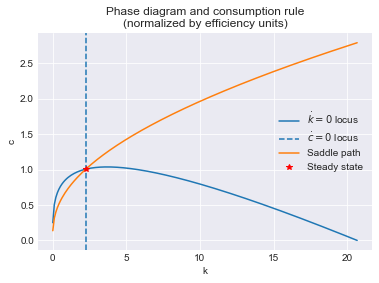

In [4]:
model.phase_diagram()

The class can also simulate the dynamics of capital given a starting point.

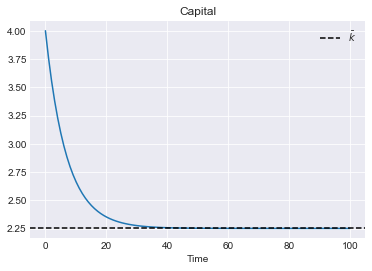

In [5]:
# Create grid of time points
t = np.linspace(0,100,100)

# Find capital dynamics at the desired time points and with
# a given starting capital
k0 = 4
k = model.k_dynamics(k0,t)

# Plot
plt.plot(t,k)
plt.axhline(y = model.kss,linestyle = '--',color = 'k', label = '$\\bar{k}$')
plt.title('Capital')
plt.xlabel('Time')
plt.legend()
plt.show()

With capital, the consumption rule can be used to find the dynamics of consumption.

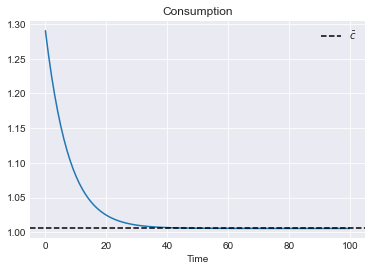

In [6]:
# Find consumption
c = model.cFunc(k)

# Plot
plt.plot(t,c)
plt.axhline(y = model.css,linestyle = '--',color = 'k', label = '$\\bar{c}$')
plt.title('Consumption')
plt.xlabel('Time')
plt.legend()
plt.show()